# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
#!pip install pygame

C:\Users\Zhan\miniconda3\envs\rl_env\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


state vector dim = 4
n_actions = 2


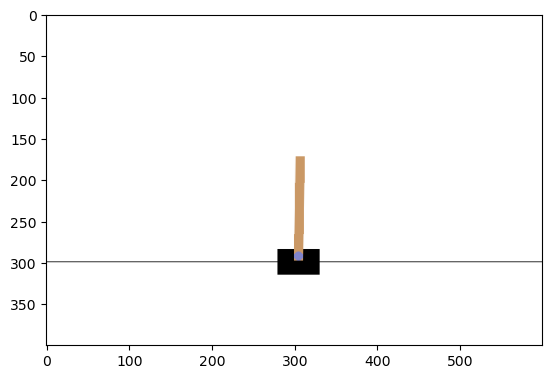

In [11]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape [len(states), n_actions]


In [12]:
env.reset()

array([-0.00728262,  0.03182504, -0.01535735, -0.03391102], dtype=float32)

In [13]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [14]:
s = env.reset()
probs = agent.predict_proba([s]).reshape(-1)
np.random.choice(2, p=probs)

1

In [ ]:
s = env_moon.reset()
probs = agent.predict_proba([s]).reshape(-1)
np.random.choice(4, p=probs)

In [21]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s]).reshape(-1)

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n, p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [17]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[ 0.02773786 -0.01067856  0.04440895  0.03603622]
 [ 0.02752429 -0.20640829  0.04512968  0.34239328]
 [ 0.02339613 -0.4021423   0.05197755  0.648959  ]
 [ 0.01535328 -0.20778145  0.06495672  0.37308598]
 [ 0.01119765 -0.0136395   0.07241844  0.10157105]]
actions: [0, 0, 1, 1, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [18]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []
    
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
            
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [19]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [10]:
# reset environment and agent
env.reset()

agent = MLPClassifier(hidden_layer_sizes=(20, 20),
                      activation='tanh')
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

mean reward = 199.490, threshold=224.900


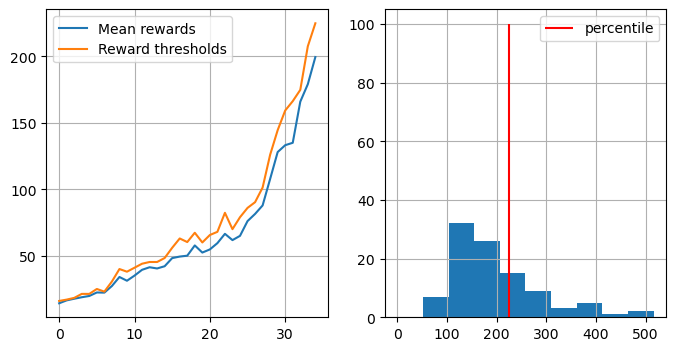

You Win! You may stop training now via KeyboardInterrupt.


In [34]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent, t_max=10**4) for _ in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    # <YOUR CODE: partial_fit agent to predict elite_actions(y) from elite_states(X)>
    agent.partial_fit(elite_states, elite_actions)
    
    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Results

In [36]:
#!pip install imageio-ffmpeg

     -------------------------------------- 22.6/22.6 MB 499.3 kB/s eta 0:00:00


In [18]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="video1_cartpole", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

C:\Users\Zhan\miniconda3\envs\rl_env\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [21]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('video1_cartpole').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


1. Создал пайплайн обучения для задачи такси
2. Перебрал различные перцентили и нарисовал кривые обучения
3. Перебрал различное количество сессий и нарисовал кривые обучения
4. Подобрал параметры, чтобы средний скор был положительный

### 1.1 Зависимость от гиперпараметров

In [22]:
env1 = gym.make("Taxi-v3")
env1.reset()

n_states = env1.observation_space.n
n_actions = env1.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


In [8]:
def generate_session1(env, policy, t_max=10**4):
    states, actions = [], []
    total_reward = 0.

    s = env.reset()  # current state

    for t in range(t_max):
        a = np.random.choice(n_actions, p=policy[s])
        new_s, r, done, info = env.step(a)
        
        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward


def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    
    return policy


def get_new_policy(elite_states, elite_actions):
    new_policy = np.zeros([n_states, n_actions])
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1
        
    new_policy[new_policy.sum(axis=1) == 0] = 1
    
    # нормируем на количество посещений state
    new_policy = new_policy / new_policy.sum(axis=1, keepdims=True)
    
    return new_policy

In [9]:
env1.reset()
policy = initialize_policy(n_states, n_actions)

In [52]:
from tqdm import tqdm, trange

def learning1(env, policy, n_sessions, percentile, lr):
    """
    Пайплайн обучения без критерия остановки (100 итераций)
    :env: среда обучения
    :policy: текущая политика
    :n_sessions: количество сессий/ размер выборки
    :percentile: перцентиль для выбора элит
    :returns: log история средних наград и трешхолдов
    """
    log = []
    for _ in tqdm(range(100)):
        sessions = [generate_session1(env1, policy, t_max=10**4) for _ in range(n_sessions)]
        
        states_batch, actions_batch, rewards_batch = zip(*sessions)
        
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
        
        new_policy = get_new_policy(elite_states, elite_actions)
        
        policy = lr * new_policy + (1 - lr) * policy
        
        mean_reward = np.mean(rewards_batch)
        threshold = np.percentile(rewards_batch, percentile)
        log.append([mean_reward, threshold])
        
    return log

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


percentile = 20, mean reward = -167.580, threshold=-227.000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]


percentile = 40, mean reward = -127.040, threshold=-21.200


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  4.00it/s]


percentile = 50, mean reward = -214.030, threshold=-30.500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


percentile = 60, mean reward = -278.320, threshold=-17.200


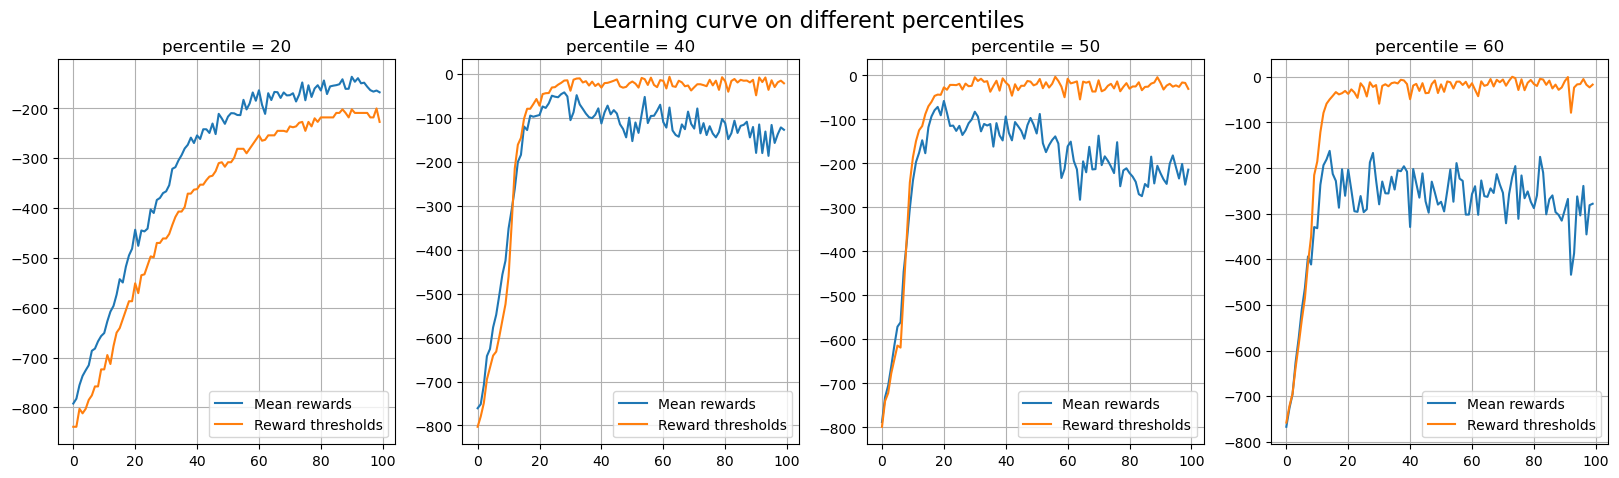

In [55]:
n_sessions = 100
percentile_list = [20, 40, 50, 60]
lr = 0.5

fig = plt.figure(figsize=[20, 5])
fig.suptitle("Learning curve on different percentiles", fontsize=16)

for i, percentile in enumerate(percentile_list):
    # reset policy and env
    policy = initialize_policy(n_states, n_actions)
    env1.reset()
    
    # learning
    log = learning1(env1, policy, 
                    n_sessions=n_sessions, 
                    percentile=percentile, 
                    lr=lr)
    mean_reward, threshold = log[-1]
    print("percentile = %.0f, mean reward = %.3f, threshold=%.3f" % (percentile, mean_reward, threshold))
    
    # plot learning curves
    ax = plt.subplot(1, 4, i+1)
    ax.set_title(f"percentile = {percentile}")
    ax.plot(list(zip(*log))[0], label='Mean rewards')
    ax.plot(list(zip(*log))[1], label='Reward thresholds')
    ax.legend()
    ax.grid()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.59it/s]


n_sessions = 50, mean reward = -277.880, threshold=-213.600


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.68it/s]


n_sessions = 100, mean reward = -153.860, threshold=-23.800


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


n_sessions = 150, mean reward = -79.553, threshold=-6.000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.18it/s]


n_sessions = 200, mean reward = -12.420, threshold=3.000


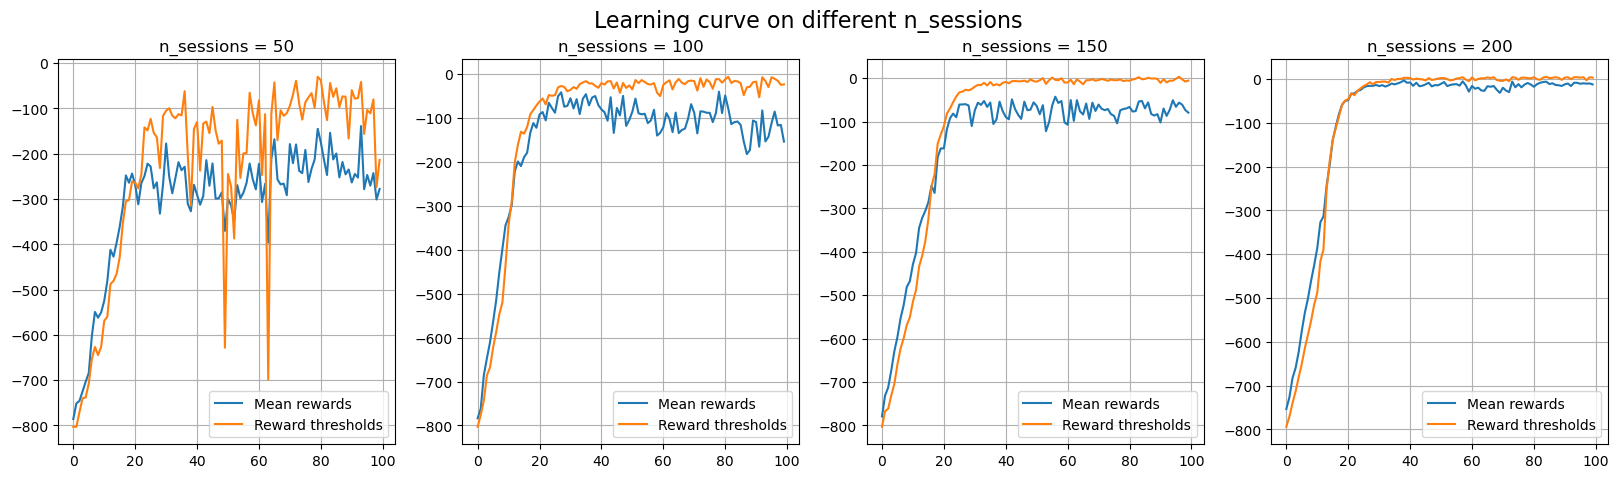

In [53]:
n_sessions_list = [50, 100, 150, 200]
percentile = 40
lr = 0.5

fig = plt.figure(figsize=[20, 5])
fig.suptitle("Learning curve on different n_sessions", fontsize=16)

for i, n_sessions in enumerate(n_sessions_list):
    # reset policy and env
    policy = initialize_policy(n_states, n_actions)
    env1.reset()
    
    # learning
    log = learning1(env1, policy, 
                    n_sessions=n_sessions, 
                    percentile=percentile, 
                    lr=lr)
    mean_reward, threshold = log[-1]
    print("n_sessions = %.0f, mean reward = %.3f, threshold=%.3f" % (n_sessions, mean_reward, threshold))
    
    # plot learning curves
    ax = plt.subplot(1, 4, i+1)
    ax.set_title(f"n_sessions = {n_sessions}")
    ax.plot(list(zip(*log))[0], label='Mean rewards')
    ax.plot(list(zip(*log))[1], label='Reward thresholds')
    ax.legend()
    ax.grid()

### Влияние параметров
`percentile`\
Увеличивая перцентиль мы отбрасываем все бОльшую долю наихудших сессий, оставляя меньше элитных. Видно, что обучение идет медленее с меньшим перцентилем. Если он будет слишком маленький, то мы не будем отбрасывать достаточно неудачных сессий. Если он будет слишком большой, то выйдет так, что хорошие сессии тоже будут отбрасываться. Более того, обучение будет сильно зависеть от инициализации и первых "разгоночных" батчей. 

`n_sessions`\
Тут логика довольно простая, чем больше сессий в батче, тем более стабильные средние награды выходят. Отсюда более плавная сходимость к оптимуму.

### 1.2 Положительный скор на Taxi

mean reward = 0.116, threshold=0.000


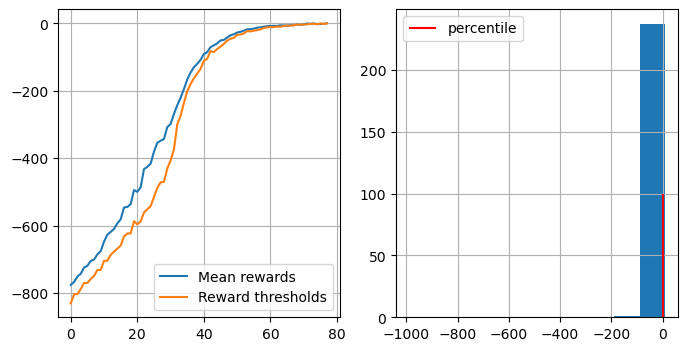

In [62]:
policy = initialize_policy(n_states, n_actions)
env1.reset()
log = []

n_sessions = 250
percentile = 30
lr = 0.3

for i in range(200):
    sessions = [generate_session1(env1, policy, t_max=10**4) for _ in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    new_policy = get_new_policy(elite_states, elite_actions)
    policy = lr * new_policy + (1 - lr) * policy

    show_progress(rewards_batch, log, percentile)
    
    if np.mean(rewards_batch) > 0:
        break

**Done!**

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

### 2.1 Выбиваем скор на MountainCar

In [24]:
np.random.seed(2023)
env = gym.make("MountainCar-v0").env
env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]
n_actions, state_dim

(3, 2)

In [32]:
np.random.seed(2023)
agent_car = MLPClassifier(
    hidden_layer_sizes=(80, 40),
    activation='tanh',
)
agent_car.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 40))

In [30]:
s = env.reset()
probs = agent_car.predict_proba([s]).reshape(-1)
probs

array([0.39049926, 0.29219617, 0.31730457])

In [31]:
import time

mean reward = -147.730, threshold=-147.000


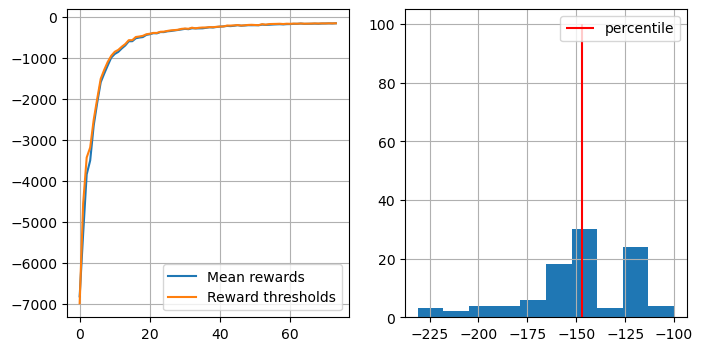

Done!
CPU times: total: 15min 26s
Wall time: 14min 23s


In [50]:
%%time
np.random.seed(2023)
n_sessions = 100
percentile = 50
log = []

for _ in range(200):
    sessions = [generate_session(env, agent_car, t_max=10**4) for _ in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent_car.partial_fit(elite_states, elite_actions)
    
    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), -100])
    
    if np.mean(rewards_batch) > -150:
        print("Done!")
        break

In [53]:
import gym.wrappers

with gym.wrappers.Monitor(gym.make("MountainCar-v0").env, directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent_car) for _ in range(100)]

In [54]:
video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
data_url = str(video_paths[-1])  # You can also try other indices

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

In [26]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)


**Решающее пространство для `mean_reward ~ -150`**

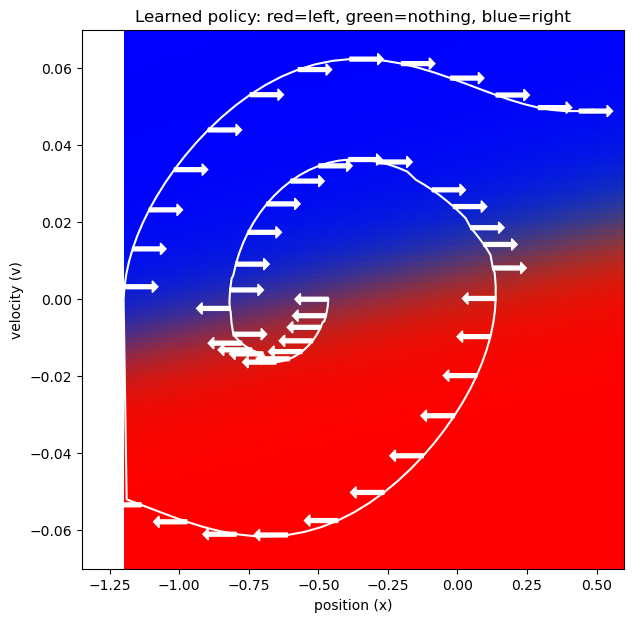

In [52]:
with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent_car)

### 2.2 Параллелим MountainCar

In [36]:
from joblib import Parallel, delayed, parallel_backend

In [39]:
%%time
sessions = [generate_session(env, agent_car, t_max=10**4) for _ in range(10)]

CPU times: total: 54.5 s
Wall time: 55 s


In [37]:
%%time
with parallel_backend('loky', inner_max_num_threads=-1):
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(gym.make( "MountainCar-v0").env, agent_car, t_max=10**4) for _ in range(10))

CPU times: total: 2.7 s
Wall time: 24.4 s


На всякий случай импортим все что надо

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
from tqdm import tqdm, trange
from joblib import Parallel, delayed, parallel_backend

In [2]:
# создаем environment
np.random.seed(2023)
env = gym.make("MountainCar-v0").env
env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]
n_actions, state_dim

(3, 2)

In [3]:
# reset policy and env
np.random.seed(2023)
env.reset()

agent_car = MLPClassifier(
    hidden_layer_sizes=(80, 40, 20),
    activation='tanh',
)
agent_car.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 40, 20))

mean reward = -102.517, threshold=-103.000


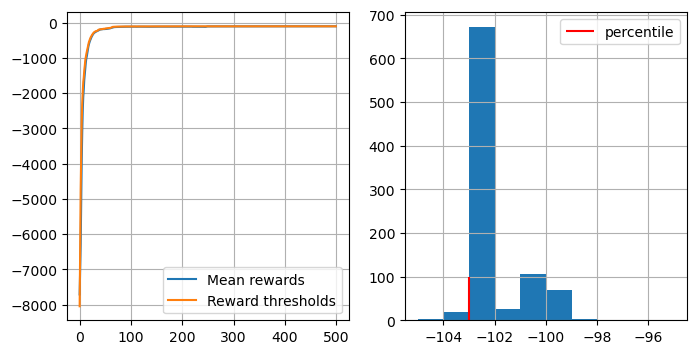

CPU times: total: 39min 34s
Wall time: 38min 6s


In [5]:
%%time
np.random.seed(2023)
n_sessions = 500
percentile = 60
log = []
q_size = 3
queue = []  # храним последние n_sessions * q_size = 500 * 3 = 1500 сессий

for _ in range(500):
    
    sessions = Parallel(n_jobs=-1, backend="loky")(delayed(generate_session)(gym.make("MountainCar-v0").env, agent_car, t_max=10**4) for _ in range(n_sessions))
    last_rewards_batch = np.array(list(zip(*sessions))[2])  # награда последнего батча, на ней валидируемся
    
    queue += sessions
    if len(queue) > (n_sessions * q_size):
        queue = queue[-(n_sessions * q_size):]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*queue))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent_car.partial_fit(elite_states, elite_actions)
    
    show_progress(last_rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), -95])
    
    if np.mean(last_rewards_batch) > -100:
        print("Done!")
        break

Не хватило итераций, постаивл еще на дообучение

mean reward = -99.584, threshold=-92.000


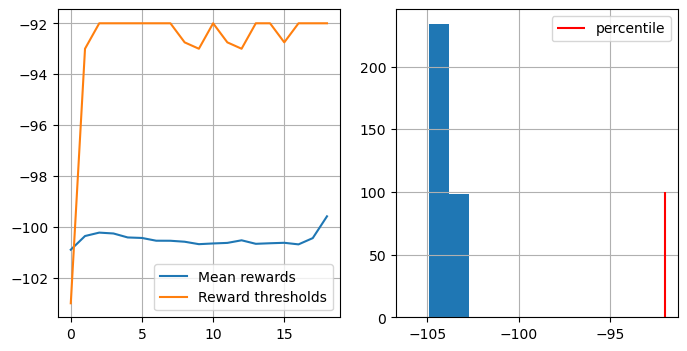

Done!
CPU times: total: 1min 17s
Wall time: 1min 16s


In [22]:
%%time
np.random.seed(2023)
n_sessions = 500
percentile = 75
log = []
q_size = 3
queue = []  # храним последние n_sessions * q_size = 500 * 3 = 1500 сессий

for _ in range(500):
    
    sessions = Parallel(n_jobs=-1, backend="loky")(delayed(generate_session)(gym.make("MountainCar-v0").env, agent_car, t_max=10**4) for _ in range(n_sessions))
    last_rewards_batch = np.array(list(zip(*sessions))[2])  # награда последнего батча, на ней валидируемся
    
    queue += sessions
    if len(queue) > (n_sessions * q_size):
        queue = queue[-(n_sessions * q_size):]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*queue))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent_car.partial_fit(elite_states, elite_actions)
    
    show_progress(last_rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), -95])
    
    if np.mean(last_rewards_batch) > -100:
        print("Done!")
        break

In [23]:
with gym.wrappers.Monitor(gym.make("MountainCar-v0").env, directory="video2_mountaincar", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent_car) for _ in range(100)]

In [33]:
video_paths = sorted([s for s in Path('video2_mountaincar').iterdir() if s.suffix == '.mp4'])
data_url = str(video_paths[-1])  # You can also try other indices

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

Здесь мы не ударяемся об левую стенку, а разгоняемся ровно настолько, чтобы хватило потом доехать до финиша.

**Решающее пространство для `mean_reward ~ -100`**

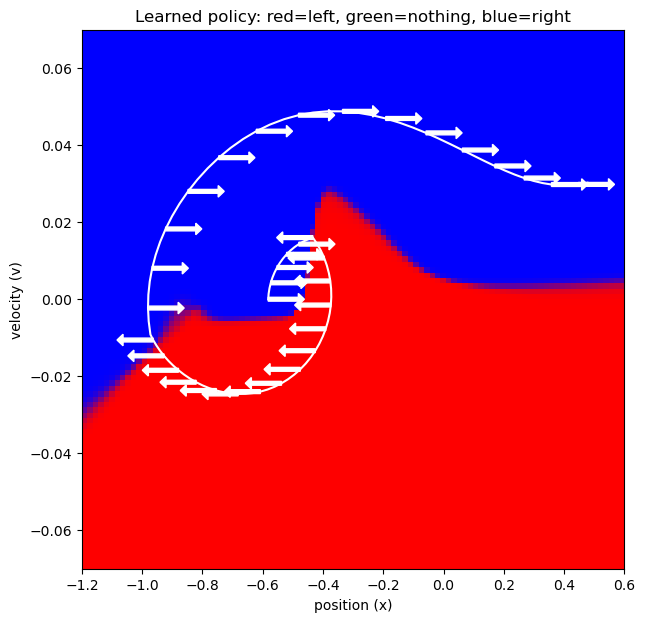

In [27]:
with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent_car)

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.

### 2.3 LunarLander
Используем ту же архитектуру и пайплайн, что и для MountainCar

In [3]:
# !pip install box2d-py

In [5]:
# создаем environment
np.random.seed(2023)
env_moon = gym.make("LunarLander-v2").env
env_moon.reset()

n_actions = env_moon.action_space.n
state_dim = env_moon.observation_space.shape[0]
n_actions, state_dim

(4, 8)

In [7]:
env_moon.reset()

array([ 0.00465212,  1.3995047 ,  0.4711942 , -0.5073482 , -0.00538386,
       -0.10673262,  0.        ,  0.        ], dtype=float32)

In [6]:
# reset policy and env
np.random.seed(2023)
env_moon.reset()

agent_lander = MLPClassifier(
    hidden_layer_sizes=(80, 40, 20),
    activation='tanh',
)
agent_lander.partial_fit([env_moon.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 40, 20))

mean reward = 55.610, threshold=73.728


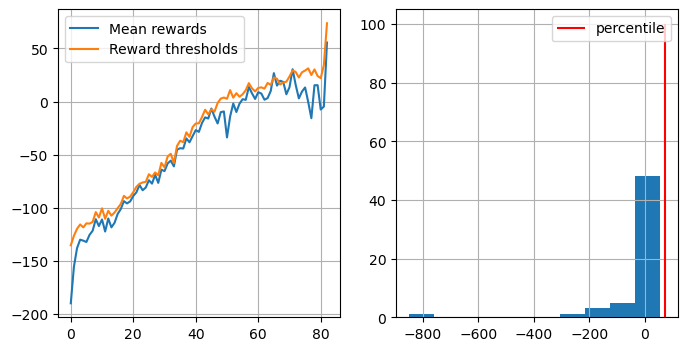

Done!
CPU times: total: 2min 39s
Wall time: 27min 29s


In [23]:
%%time
np.random.seed(2023)
n_sessions = 100
percentile = 60
log = []
q_size = 3
queue = []  # храним последние n_sessions * q_size = 100 * 3 = 300 сессий

for _ in range(500):
    sessions = Parallel(n_jobs=-1, backend="loky")(delayed(generate_session)(env_moon, agent_lander, t_max=10**4) for _ in range(n_sessions))
    last_rewards_batch = np.array(list(zip(*sessions))[2])  # награда последнего батча, на ней валидируемся
    
    queue += sessions
    if len(queue) > (n_sessions * q_size):
        queue = queue[-(n_sessions * q_size):]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*queue))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent_lander.partial_fit(elite_states, elite_actions)
    
    show_progress(last_rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 55])
    
    if np.mean(last_rewards_batch) > 50:
        print("Done!")
        break

In [26]:
with gym.wrappers.Monitor(gym.make("LunarLander-v2"), directory="video3_lunarlander", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent_lander) for _ in range(100)]

In [32]:
video_paths = sorted([s for s in Path('video3_lunarlander').iterdir() if s.suffix == '.mp4'])
data_url = str(video_paths[-4])  # You can also try other indices

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

Заметил, что после приземления корабль еще долго стоит с включенными двигателями, что каждую секунду уменьшает количество очков. Можно было бы еще задать ограничение на количество топлива, чтоб оно просто так не расходовалось, но это слишком специфичная эвристика для данной задачи. Модель сама должна выучиться вовремя отключать двигатели.